# Initializations

> Weights should be initialized apropriately

Adapted from:

- [https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s](https://www.youtube.com/watch?v=vGsc_NbU7xc&t=129s)

In [1]:
#| default_exp initializations

In [106]:
# |export
import math
import random
from contextlib import contextmanager
from functools import partial

import fastcore.all as fc
import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F
from einops import rearrange
from torch import Tensor, nn
from torch.nn import init
from torchmetrics.classification import MulticlassAccuracy

from slowai.activations import (
    Conv2dWithReLU,
    Hook,
    HooksCallback,
    StoreModuleStats,
    StoreModuleStatsCB,
    set_seed,
)
from slowai.convs import to_device
from slowai.datasets import get_grid, show_image
from slowai.learner import (
    Callback,
    DeviceCB,
    LRFinderCB,
    MetricsCB,
    MomentumCB,
    ProgressCB,
    TrainLearner,
    fashion_mnist,
    to_cpu,
)
from slowai.utils import clean_mem

In [86]:
clean_mem()

In [3]:
set_seed(42)
plt.style.use("ggplot")

## Probability, Miscellaneous

- "Average error" is typically 0 because positive and negative errors cancel out, making this metric not useful. We avoid this by using "{Root, }Mean Squared Error," which counts large errors more strongly
- **Variance**

> In probability theory and statistics, variance is the expected value of the squared deviation from the mean of a random variable

[https://en.wikipedia.org/wiki/Variance](https://en.wikipedia.org/wiki/Variance)

$$\sigma^2 = \sum \frac{(x-\mathbb{E}[X])^2}{N}$$

  This version is quicker to calculate:

$$\sigma^2 = \mathbb{E}[X^2] - \mathbb{E}[X]^2$$

- **Convariance**

> Covariance in probability theory and statistics is a measure of the joint variability of two random variables.

[https://en.wikipedia.org/wiki/Covariance](https://en.wikipedia.org/wiki/Covariance)

$$\operatorname{cov}(X,Y) = \operatorname{E}{\big[(X - \operatorname{E}[X])(Y - \operatorname{E}[Y])\big]}$$

You can think about this as the average product of residuals of different features. If two features "co-vary," these products will be very large or very small; if not, they the products will be totally random and the sum will be small (because different directions cancel eachother out).

- **Pearson correlation coefficient**

$$\rho_{X,Y}= \frac{\operatorname{cov}(X,Y)}{\sigma_X \sigma_Y}$$

Think of this as a __normalized covariance__. 

## Baseline

Let's look at a fashion MNIST classification problem. Our goal is to get accuracy to at least 90%.

In [4]:
class CNN(nn.Module):
    """Six layer convolutional neural network"""

    def __init__(self):
        super().__init__()
        self.layers = nn.Sequential(
            Conv2dWithReLU(1, 8, kernel_size=5, stride=2, padding=2),  # 14x14
            Conv2dWithReLU(8, 16, kernel_size=3, stride=2, padding=1),  # 7x7
            Conv2dWithReLU(16, 32, kernel_size=3, stride=2, padding=1),  # 4x4
            Conv2dWithReLU(32, 64, kernel_size=3, stride=2, padding=1),  # 2x2
            nn.Conv2d(64, 10, kernel_size=3, stride=2, padding=1),  # 1x1
        )

    def forward(self, x):
        x = self.layers(x)
        return rearrange(x, "bs c w h -> bs (c w h)")

Let's start by finding the learning rate.

This diverges very quickly

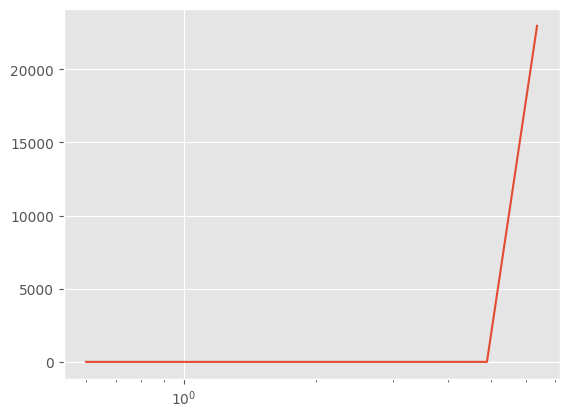

In [5]:
TrainLearner(
    CNN(),
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=[LRFinderCB(), MomentumCB()],
).fit()

That's unusable. Let's dial down the learning rate increase and start at a lower learning rate.

In [6]:
LRFinderCB?

Init signature: LRFinderCB(gamma=1.3, max_mult=3)
Docstring:     
Find an apopriate learning rate by increasing it by a constant factor for each batch
until the loss diverges
File:           ~/Desktop/SlowAI/nbs/slowai/learner.py
Type:           type
Subclasses:     

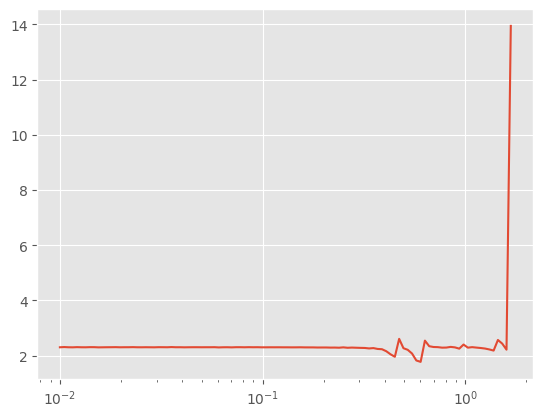

In [7]:
TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05), MomentumCB()],
).fit()

MulticlassAccuracy,loss,epoch,train
0.168,2.378,0,train
0.100,2.301,0,eval
0.165,2.262,1,train
0.200,2.239,1,eval


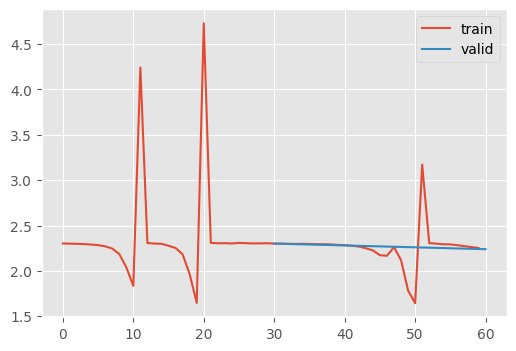

In [8]:
model = CNN()
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MomentumCB(),
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    stats,
]
TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.6,
    cbs=cbs,
).fit(2)

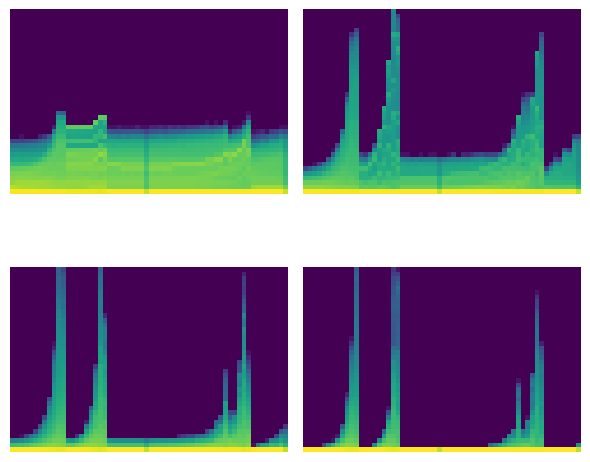

In [9]:
stats.hist_plot()

The issue with neural networks in real life is that they must be represented by discrete data structures. These can overflow...

In [10]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100)
x[0:5, 0:5]

tensor([[nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan],
        [nan, nan, nan, nan, nan]])

...or underflow..

In [11]:
x = torch.randn(200, 100)
for i in range(50):
    x = x @ torch.randn(100, 100) * 0.01
x[0:5, 0:5]

tensor([[0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0.]])

We should scale our weights such that, throughout the training process, the mean remains near 0 and the standard deviation remains near 1. Otherwise, we are suseptible to these "dead units"

## Glorot/Xavier

Normally, the mean variance of a layer is approximately the number of output dimensions

In [12]:
for d in [1, 100]:
    means = []
    sqrs = []

    for _ in range(500):
        x = torch.randn(d)
        a = torch.randn(512, d)
        y = a @ x
        means.append(y.mean())
        sqrs.append(y.pow(2).mean())

    res = torch.stack(means).mean(), torch.stack(sqrs).mean()
    print(res)

(tensor(-0.0011), tensor(1.1372))
(tensor(-0.0029), tensor(100.2205))




To encourage of variance of 1, the paper from Xavier Glorot and Yoshua Bengio proposed that each layer have a coefficient of $\frac{1}{\sqrt{d}}$ where $d$ is the number of inputs

In [13]:
d = 100
x = torch.randn(200, d)
for i in range(50):
    layer = torch.randn(d, d) * (1 / math.sqrt(d))
    x = x @ layer
x[0:5, 0:5]

tensor([[ 1.7367, -0.3418, -2.1874, -0.9467,  1.0451],
        [ 0.7802,  0.3702, -0.9278,  0.1607,  0.7578],
        [-2.0552,  1.0210,  1.7889,  0.1260, -1.0092],
        [-0.4922, -0.1349,  0.0443, -0.3037, -0.1711],
        [ 0.0103,  0.0468, -0.6201, -1.1773,  0.1258]])

Indeed, this gives us reasonable numbers! However, this doesn't work for modern deep learning because of the **activation layers**.


## Kaiming/He init

Notice that the first layer of a neural network has a favorable activation distribution

In [14]:
d1, d2 = 100, 100
x = torch.randn(200, d1)
y = torch.randn(200)
w = torch.randn(d1, d2) / math.sqrt(d1)
b = torch.zeros(d2)

In [15]:
l1 = x @ w + b
l1.mean(), l1.std()

(tensor(0.0034), tensor(0.9888))

But what happens when we add non-linearities?

In [16]:
def relu(x):
    return x.clamp_min(0.0)


l1r = relu(l1)
l1r.mean(), l1r.std()

(tensor(0.3943), tensor(0.5795))

Indeed, this property is lost...thus goes the path to ruin...

In [17]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(1 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

tensor([[3.6994e-08, 0.0000e+00, 9.4013e-09, 1.5577e-08, 1.0590e-08],
        [5.5068e-08, 0.0000e+00, 1.1871e-08, 2.4266e-08, 1.3567e-08],
        [9.3161e-08, 0.0000e+00, 2.2955e-08, 4.0294e-08, 2.4063e-08],
        [4.9314e-08, 0.0000e+00, 1.1283e-08, 2.1542e-08, 1.3132e-08],
        [3.8813e-08, 0.0000e+00, 9.7021e-09, 1.6069e-08, 1.1153e-08]])

To rectify this situation, Kaiming proposed using $\sqrt{\frac{2}{d}}$ 😂

In [18]:
l = l1r
for _ in range(50):
    w = torch.randn(d2, d2) * math.sqrt(2 / d2)
    l = relu(l @ w)
l[0:5, 0:5]

tensor([[0.0218, 0.0350, 0.0000, 0.4040, 0.0000],
        [0.1481, 0.0000, 0.0000, 0.5991, 0.0000],
        [0.0582, 0.1006, 0.0000, 0.7180, 0.0162],
        [0.1623, 0.0000, 0.0000, 0.9592, 0.0000],
        [0.1217, 0.0169, 0.0000, 0.6792, 0.0000]])

Notice, there are still positive numbers even after 50 layers!

This is the best way to initialize a network. But how do we do this on a code level? We use the `.apply()` method.

In [19]:
def init_weights(module):
    # `kaiming_normal_` is an in-place operation, unlike `kaiming_normal`
    if not isinstance(module, (nn.Sequential, Conv2dWithReLU, CNN)):
        init.kaiming_normal_(module.weight)

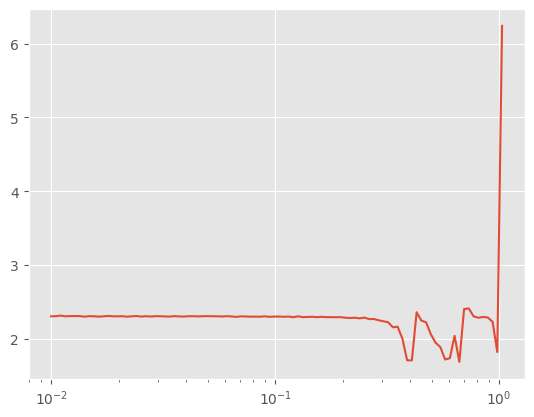

In [20]:
model = CNN()
model.apply(init_weights)
learn = TrainLearner(
    CNN(),
    fashion_mnist(64),
    F.cross_entropy,
    lr=1e-2,
    cbs=[LRFinderCB(gamma=1.05), MomentumCB()],
).fit()

Better! Let's try training with 0.25.

MulticlassAccuracy,loss,epoch,train
0.547,1.434,0,train
0.718,0.717,0,eval
0.748,0.654,1,train
0.763,0.624,1,eval


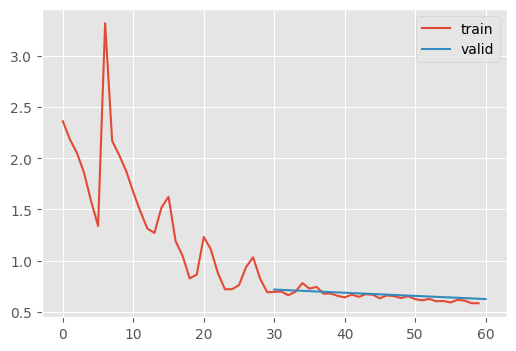

In [21]:
model = CNN()
model.apply(init_weights)
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    MomentumCB(),
    stats,
]
TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
).fit(2)

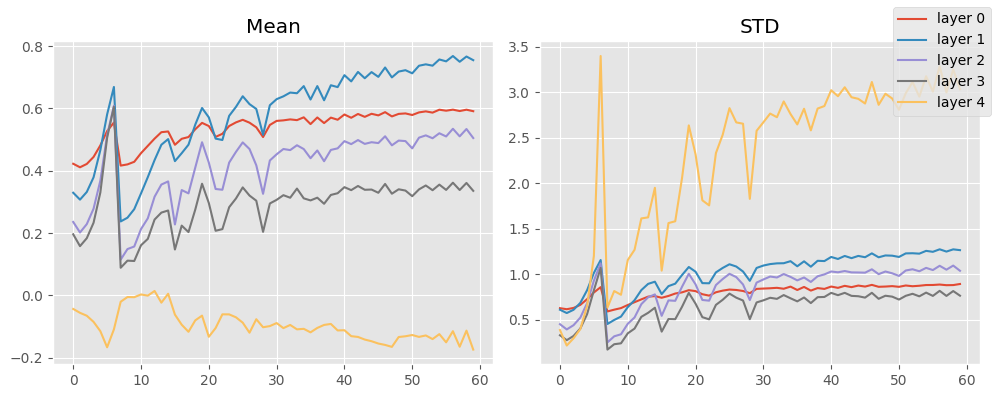

In [22]:
stats.mean_std_plot()

That's okay. Keep in mind, I didn't include momentum, like Jeremy; but I did globally normalize the inputs.

Let's try normalizing batchwise.

In [23]:
# |export
class BatchTransformCB(Callback):
    """Arbitrarily transform a batch"""

    def __init__(self, tfm, on_train=True, on_val=True):
        fc.store_attr()

    def before_batch(self, learn):
        if (self.on_train and learn.training) or (self.on_val and not learn.training):
            learn.batch = self.tfm(learn.batch)

In [24]:
# |export
class NormalizeBatchCB(BatchTransformCB):
    """Unit normalize a batch"""

    def __init__(self, on_train=True, on_val=True):
        fc.store_attr()

    def tfm(self, batch):
        xb, *other = batch
        mu = xb.mean()
        sigma = xb.std()
        return (xb - mu) / sigma, *other

MulticlassAccuracy,loss,epoch,train
0.550,1.401,0,train
0.708,0.809,0,eval
0.756,0.663,1,train
0.773,0.626,1,eval


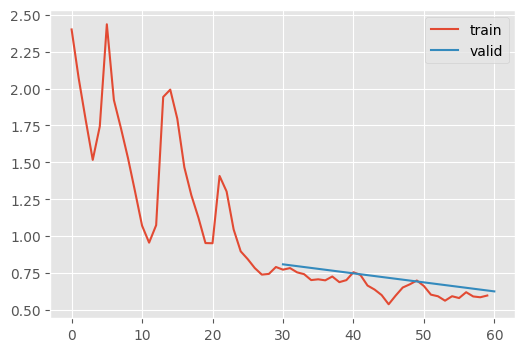

In [25]:
model = CNN()
model.apply(init_weights)
stats = StoreModuleStatsCB(mods=model.layers)
dls = fashion_mnist()
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

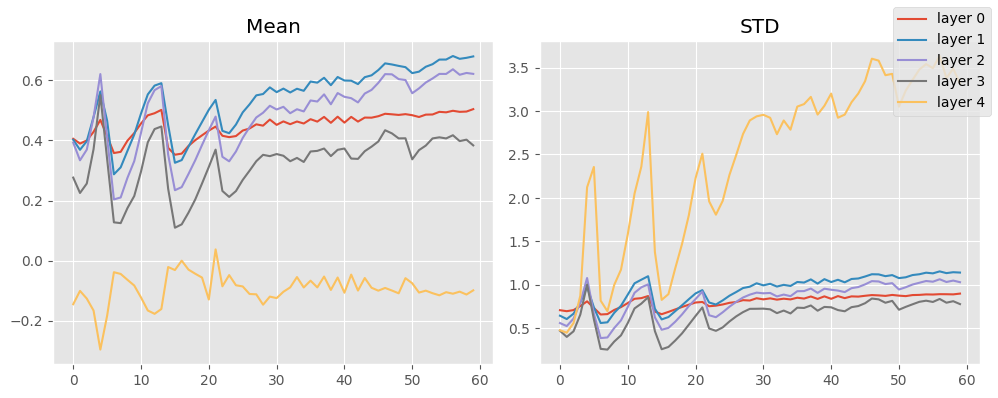

In [26]:
stats.mean_std_plot()

This isn't much better, unsurprisingly since it was already normalized.

## Why are these activations distribution not unit normal? 

The problem is the `StoreModuleStatsCB` looks at the **output** of the ReLU + Convolutional blocks, which cannot output negative numbers (except for the last layer which does not have an non-linearity). Therefore, their output **cannot** look unit normal!

What if we modified ReLU to allow unit normality?

$$
\text{GeneralReLU}_{l,r,m}(x) = max(\{m, 
\left.
  \begin{cases}
    x & \text{if } x > 0 \\
    l \cdot x & \text{otherwise}
  \end{cases}
  \right\} - r
\})
$$

In [33]:
class GeneralReLU(nn.Module):
    def __init__(self, leak=None, sub=None, max_=None):
        super().__init__()
        self.leak = leak
        self.sub = sub
        self.max_ = max_

    def forward(self, x):
        if self.leak:
            x = F.leaky_relu(x, self.leak)
        else:
            x = F.relu(x)
        if self.sub:
            x -= self.sub
        if self.max_:
            x.clamp_max_(self.max_)
        return x

This should output a roughly unit normal distribution by pushing all the values down and allowing some contribution from negative values.

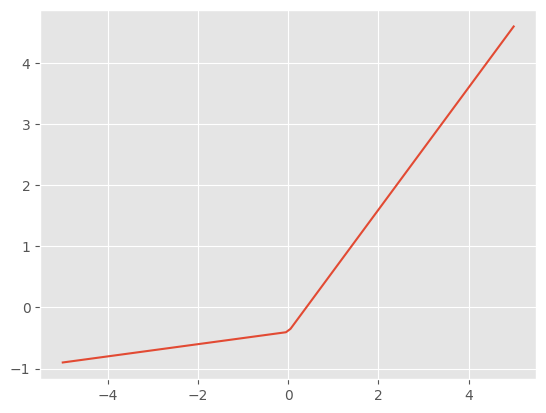

In [34]:
x = torch.linspace(-5, 5, steps=100)
gr = GeneralReLU(leak=0.1, sub=0.4)
plt.plot(x, gr(x));

In [62]:
C = Conv2dWithReLU


class CNNWithGeneralReLU(nn.Module):
    """Six layer convolutional neural network with GeneralRelU"""

    def __init__(self, gr=lambda: GeneralReLU(leak=0.1, sub=0.4)):
        super().__init__()
        layers = [  #
            C(1, 8, kernel_size=5, stride=2, padding=2, nonlinearity=gr()),  # 14x14
            C(8, 16, 3, 2, 1, nonlinearity=gr()),  # 7x7
            C(16, 32, 3, 2, 1, nonlinearity=gr()),  # 4x4
            C(32, 64, 3, 2, 1, nonlinearity=gr()),  # 2x2
            nn.Conv2d(64, 10, 3, 2, 1),  # 1x1
        ]
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        *_, w, h = x.shape
        assert w == h == 1
        return rearrange(x, "bs c w h -> bs (c w h)")

⚠️ Now that we are no longer using ReLU outputs, so Kaiming initialization is not acceptable! Luckily, there is an adjustment for this leaky property in the pytorch script

In [63]:
def init_leaky_weights(module, leak=0.0):
    if isinstance(module, (nn.Conv2d,)):
        init.kaiming_normal_(
            module.weight,
            a=leak,  # 👈 weirdly, called `a` here
        )

MulticlassAccuracy,loss,epoch,train
0.626,1.100,0,train
0.721,0.780,0,eval
0.774,0.618,1,train
0.771,0.627,1,eval


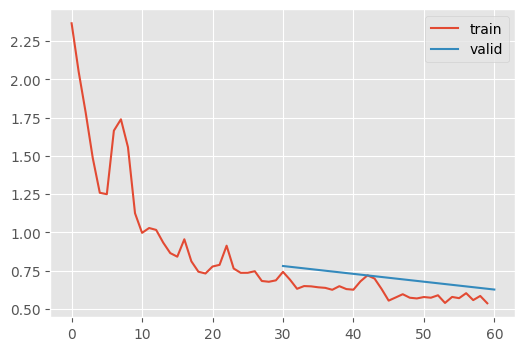

In [64]:
leak = 0.1
model = CNNWithGeneralReLU(gr=lambda: GeneralReLU(leak=leak, sub=0.4))
model.apply(partial(init_leaky_weights, leak=leak))
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    stats,
]
learn = TrainLearner(
    model,
    fashion_mnist(),
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(2)

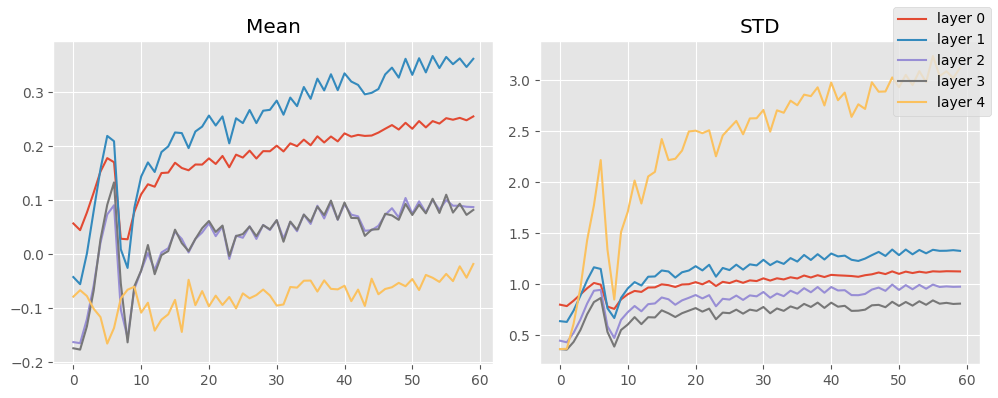

In [65]:
stats.mean_std_plot()

That looks **GREAT** 🤩 What happens if we keep on training that?

MulticlassAccuracy,loss,epoch,train
0.810,0.522,0,train
0.756,0.675,0,eval
0.827,0.476,1,train
0.800,0.557,1,eval
0.837,0.448,2,train
0.825,0.489,2,eval
0.846,0.424,3,train
0.835,0.468,3,eval
0.853,0.403,4,train
0.841,0.450,4,eval


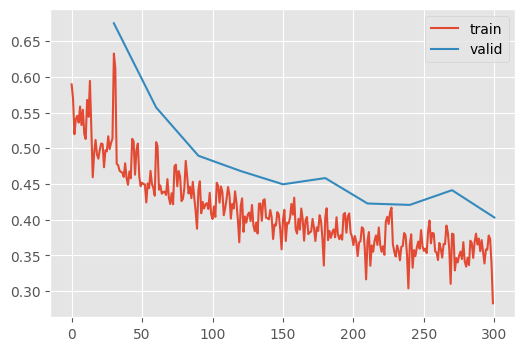

In [67]:
learn.fit(10)

86% accuracy! Not bad.

This goes to show that initialization is underappreciated.

## General Initializations

"All You Need Is a Good Init" proposed that there is a generic strategy to initialize any model.

- Setup your model any way you like
- Pass a batch of data through the model and record the layer wise activation statistics
- Apply a unit normalization
- Repeat step 2 until the activation statistics are unit normal within an acceptable tolerance

In code:

In [112]:
# |export
class LSUVHook(Hook):
    """A hook for performing LSUV for a single layer"""

    def __init__(self, m, tol=1e-3):
        self.mean = None
        self.std = None
        self.tol = tol

        def append_moments(module, _, activations):
            activations = to_cpu(activations)
            self.mean = activations.mean()
            self.std = activations.std()

        self.hook = m.register_forward_hook(append_moments)
        self.m = m

    def normalized(self):
        assert self.mean and self.std, "Attempted normalization before processing data"
        return abs(self.mean) > self.tol or abs(self.std - 1) > self.tol

    def normalize(self):
        assert self.mean and self.std, "Attempted normalization before processing data"
        self.m.bias -= self.mean
        self.m.weight.data /= self.std

In [116]:
# |export
class LSUVInitialization(HooksCallback):
    """Layer wise sequential unit variance initialization"""

    def __init__(
        self,
        seed_hook_f,
        mods=None,
        mod_filter=fc.noop,
        on_train=True,
        on_valid=False,
    ):
        fc.store_attr()
        self.hook_cls = LSUVHook

    def before_fit(self, learn):
        super().before_fit(learn)
        with torch.no_grad():
            for h in self.hooks:
                while True:
                    self.seed_hook_f()
                    if not h.normalized():
                        h.normalize()
                    else:
                        break
        # We don't need these hooks anymore, so we can get rid of them
        # before beginning training
        self.cleanup_fit(learn)
        self.hooks = []

MulticlassAccuracy,loss,epoch,train
0.221,2.224,0,train
0.479,1.648,0,eval
0.623,1.107,1,train
0.667,0.862,1,eval
0.720,0.750,2,train
0.737,0.716,2,eval
0.757,0.649,3,train
0.752,0.672,3,eval
0.773,0.596,4,train
0.766,0.634,4,eval


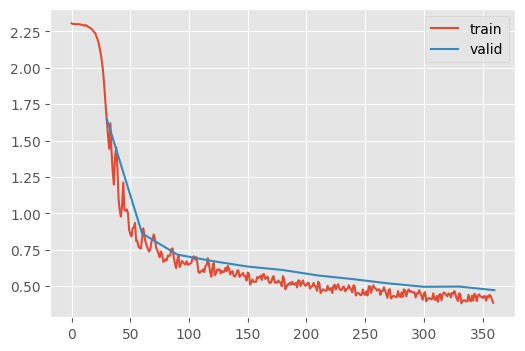

In [118]:
leak = 0.1
model = CNNWithGeneralReLU(gr=lambda: GeneralReLU(leak=leak, sub=0.4))

# Note that we're removing the `model.apply` in favor of LSUVInitialization

dls = fashion_mnist()
idls = iter(dls["train"])


def lsuv_seeder():
    batch = next(idls)
    batch = to_device(batch)
    xb, _ = batch
    model(xb)


lsuv_init = LSUVInitialization(lsuv_seeder, mods=model.layers)
stats = StoreModuleStatsCB(mods=model.layers)
cbs = [
    MetricsCB(MulticlassAccuracy(num_classes=10)),
    DeviceCB(),
    ProgressCB(plot=True),
    NormalizeBatchCB(),
    MomentumCB(),
    lsuv_init,
    stats,
]
learn = TrainLearner(
    model,
    dls,
    F.cross_entropy,
    lr=0.25,
    cbs=cbs,
)
learn.fit(12)

Its not quite as accurate, but the curvature very smoother and it looks like I could train for even longer.

MulticlassAccuracy,loss,epoch,train
0.850,0.406,0,train
0.827,0.470,0,eval
0.854,0.397,1,train
0.835,0.450,1,eval
0.857,0.387,2,train
0.834,0.452,2,eval
0.861,0.380,3,train
0.841,0.435,3,eval
0.865,0.368,4,train
0.841,0.437,4,eval


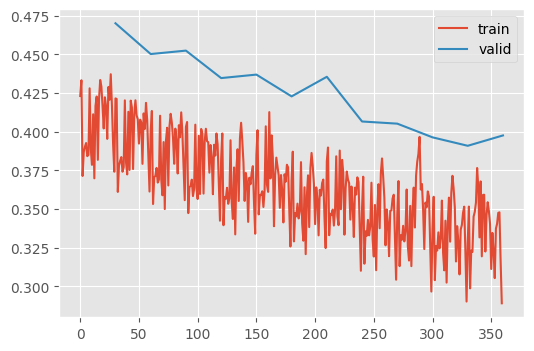

In [119]:
learn.fit(12)

86% accuracy, again. Not an improvement, but this callback approach has a better DX.

In [ ]:
#| hide
import nbdev

nbdev.nbdev_export()